In [1]:
#general package
import json
import os
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, FixedFormatter
import seaborn as sns
from dateutil.parser import parse
from itertools import combinations
 
#statistical package
from scipy.stats import pearsonr
from scipy.stats import chi2_contingency
from scipy.stats import ttest_ind
from scipy import stats

#pre-process: encoding, pca, clustering
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, silhouette_samples, calinski_harabasz_score, adjusted_rand_score

from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree

#modelling
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV

import statsmodels.api as sm
from itertools import chain, combinations
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report

In [2]:
df_bat = pd.read_csv('/Users/quinne/Desktop/dissertation_dataset/halftime_encode_python.csv')
df_bat

,Result,match_number,team_code,opponent_code,gender,season,team_score,team_wickets,winner_code,toss_winner_code,home_advantage,venue_city_code,choose_to_bat,avg_score,avg_win_rate,avg_wickets_out,last_match_result
0,1,5,4,1,0,2021,132,7,4,1,0,1,0,139.000000,1.000000,5.000000,1
1,1,6,0,2,0,2021,113,9,0,0,0,2,1,128.000000,0.000000,6.000000,0
2,1,7,3,6,0,2021,149,7,3,3,0,6,1,131.000000,1.000000,4.000000,1
3,0,8,7,5,0,2021,110,7,5,5,1,5,0,130.000000,0.000000,8.000000,0
4,1,10,6,1,0,2021,151,4,6,6,0,1,1,116.000000,0.000000,7.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,0,30,1,0,1,2022,139,6,0,0,1,0,0,140.642857,0.428571,6.571429,0
111,1,31,3,5,1,2022,135,8,3,5,1,5,0,152.714286,0.428571,6.000000,1
112,0,32,4,2,1,2022,143,9,2,4,0,2,1,145.500000,0.571429,5.785714,1
113,0,40,1,2,1,2022,150,7,2,1,0,2,1,140.533333,0.400000,6.533333,0


In [4]:
df_bat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Result             115 non-null    int64  
 1   match_number       115 non-null    int64  
 2   team_code          115 non-null    int64  
 3   opponent_code      115 non-null    int64  
 4   gender             115 non-null    int64  
 5   season             115 non-null    int64  
 6   team_score         115 non-null    int64  
 7   team_wickets       115 non-null    int64  
 8   winner_code        115 non-null    int64  
 9   toss_winner_code   115 non-null    int64  
 10  home_advantage     115 non-null    int64  
 11  venue_city_code    115 non-null    int64  
 12  choose_to_bat      115 non-null    int64  
 13  avg_score          115 non-null    float64
 14  avg_win_rate       115 non-null    float64
 15  avg_wickets_out    115 non-null    float64
 16  last_match_result  115 non

In [5]:
print(df_bat.shape)

(115, 17)


In [6]:
columns_to_keep = ['Result', "match_number", "team_code", "opponent_code", 
                   "gender", 'season', 'home_advantage', 'venue_city_code',
                   'avg_score', 'avg_win_rate', 'avg_wickets_out', 'last_match_result']
df = df_bat[columns_to_keep]

In [8]:
print(df.shape)

(115, 12)


In [7]:
X = df.drop("Result", axis=1)
y = df['Result']

In [9]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=5)

### KNN (K-Nearest Neighbors)

In [10]:
# Standardizing the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Finding the optimal parameters for KNN
knn = KNeighborsClassifier()
param_grid = {
    'n_neighbors': np.arange(1, 51),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn_gscv = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
knn_gscv.fit(X_scaled, y)

print("Best parameters for KNN:", knn_gscv.best_params_)

Best parameters for KNN: {'metric': 'euclidean', 'n_neighbors': 10, 'weights': 'uniform'}


In [11]:
knn = KNeighborsClassifier(metric='euclidean', n_neighbors=10, weights='uniform')
y_prob_knn = np.zeros_like(y, dtype=float)

for train_idx, test_idx in cv.split(X, y):
    scaler = StandardScaler()
    
    X_train = scaler.fit_transform(X.iloc[train_idx])
    X_test = scaler.transform(X.iloc[test_idx])
    
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    knn.fit(X_train, y_train)
    y_prob_knn[test_idx] = knn.predict_proba(X_test)[:, 1]

y_pred_knn = (y_prob_knn > 0.5).astype(int)

print("Predicted Probabilities for KNN:")
print(y_prob_knn)

Predicted Probabilities for KNN:
[0.5 0.5 0.7 0.2 0.6 0.3 0.2 0.6 0.4 0.1 0.3 0.6 0.2 0.9 0.6 0.1 0.4 0.5
 0.8 0.4 0.3 0.2 0.4 0.7 0.1 0.4 0.3 0.5 0.6 0.5 0.3 0.3 0.2 0.5 0.4 0.5
 0.4 0.3 0.5 0.5 0.5 0.4 0.7 0.5 0.5 0.1 0.3 0.4 0.5 0.2 0.3 0.5 0.4 0.3
 0.3 0.4 0.4 0.5 0.2 0.5 0.5 0.7 0.3 0.6 0.7 0.5 0.3 0.5 0.4 0.5 0.6 0.4
 0.3 0.4 0.5 0.4 0.6 0.5 0.3 0.5 0.4 0.4 0.6 0.5 0.6 0.5 0.5 0.7 0.5 0.8
 0.4 0.5 0.6 0.7 0.5 0.5 0.6 0.4 0.4 0.4 0.6 0.5 0.6 0.5 0.6 0.2 0.4 0.7
 0.4 0.7 0.3 0.4 0.4 0.5 0.4]


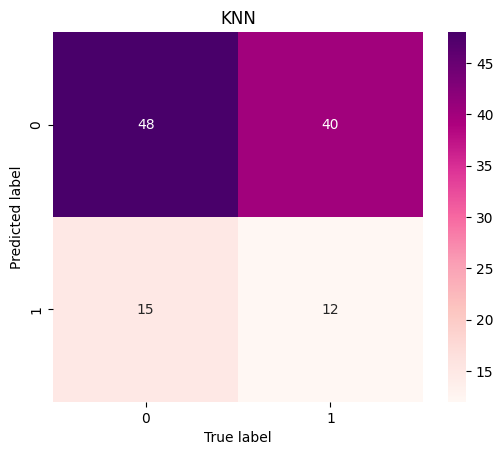

Accuracy:	0.521739
F1-score:	0.469780
Precision:	0.494949
Recall:		0.496337

Classification performance:
              precision    recall  f1-score   support

           0       0.55      0.76      0.64        63
           1       0.44      0.23      0.30        52

    accuracy                           0.52       115
   macro avg       0.49      0.50      0.47       115
weighted avg       0.50      0.52      0.49       115



In [12]:
# Evaluation for KNN
mat_knn = confusion_matrix(y, y_pred_knn)
sns.heatmap(mat_knn.T, square=True, annot=True, fmt="d", cmap="RdPu")
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.title("KNN")
plt.show()

print("Accuracy:\t%f" % accuracy_score(y, y_pred_knn))
print("F1-score:\t%f" % f1_score(y, y_pred_knn, average='macro'))
print("Precision:\t%f" % precision_score(y, y_pred_knn, average='macro'))
print("Recall:\t\t%f" % recall_score(y, y_pred_knn, average='macro'))
print("\nClassification performance:\n%s" % classification_report(y, y_pred_knn))

### SVM (Support Vector Machine) 

In [13]:
#Finding the optimal parameters for SVM
svm = SVC(probability=True)
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']}

svm_gscv = GridSearchCV(svm, param_grid, cv=10, scoring='accuracy')
svm_gscv.fit(X_scaled, y)

print("Best parameters for SVM:", svm_gscv.best_params_)

Best parameters for SVM: {'C': 1000, 'gamma': 'scale', 'kernel': 'linear'}


In [14]:
# svm = SVC(kernel='linear', probability=True)
svm = SVC(C=1000, gamma='scale', kernel='linear', probability=True)
y_prob_svm = np.zeros_like(y, dtype=float)

for train_idx, test_idx in cv.split(X, y):
    scaler = StandardScaler()
    
    X_train = scaler.fit_transform(X.iloc[train_idx])
    X_test = scaler.transform(X.iloc[test_idx])
    
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    svm.fit(X_train, y_train)
    y_prob_svm[test_idx] = svm.predict_proba(X_test)[:, 1]

y_pred_svm = (y_prob_svm > 0.5).astype(int)
print("\nPredicted Probabilities for SVM:")
print(y_prob_svm)


Predicted Probabilities for SVM:
[0.45214142 0.44995831 0.44733622 0.45600535 0.37778448 0.45812932
 0.45205069 0.45300354 0.40157238 0.45501525 0.44491923 0.39872213
 0.45292144 0.54768489 0.45191139 0.40686185 0.34083568 0.53445101
 0.45081469 0.45160945 0.4224877  0.45002091 0.45448274 0.52284403
 0.44559459 0.42902666 0.45311523 0.45375983 0.45812346 0.4797048
 0.44414257 0.43656478 0.32241049 0.42766802 0.45771749 0.44977879
 0.3814388  0.44551764 0.40308459 0.45392848 0.50724388 0.45849801
 0.46318324 0.45069957 0.45563498 0.40963616 0.45286867 0.45168546
 0.45230888 0.45364307 0.45246921 0.47728386 0.41355258 0.45249923
 0.45263372 0.481649   0.48220769 0.40377328 0.4215637  0.4262282
 0.44680393 0.45191659 0.56720532 0.43990085 0.51277497 0.48965406
 0.41454807 0.44512685 0.46884502 0.42980193 0.37983408 0.38128611
 0.40298559 0.5        0.52663153 0.45406648 0.46389338 0.42937791
 0.46508865 0.45100011 0.45236115 0.4162895  0.4318645  0.4740052
 0.44901891 0.43359249 0.482782

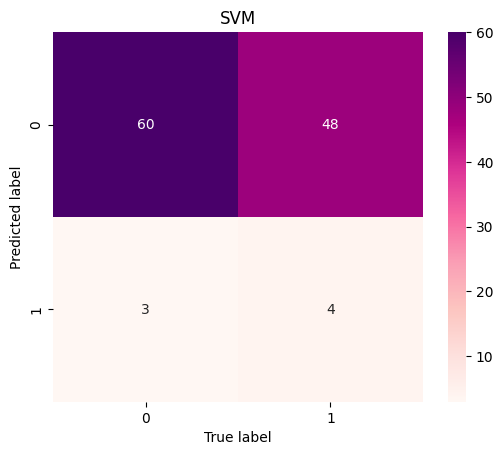

Accuracy:	0.556522
F1-score:	0.418674
Precision:	0.563492
Recall:		0.514652

Classification performance:
              precision    recall  f1-score   support

           0       0.56      0.95      0.70        63
           1       0.57      0.08      0.14        52

    accuracy                           0.56       115
   macro avg       0.56      0.51      0.42       115
weighted avg       0.56      0.56      0.45       115



In [15]:
mat_svm = confusion_matrix(y, y_pred_svm)
sns.heatmap(mat_svm.T, square=True, annot=True, fmt="d", cmap="RdPu")
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.title("SVM")
plt.show()

print("Accuracy:\t%f" % accuracy_score(y, y_pred_svm))
print("F1-score:\t%f" % f1_score(y, y_pred_svm, average='macro'))
print("Precision:\t%f" % precision_score(y, y_pred_svm, average='macro'))
print("Recall:\t\t%f" % recall_score(y, y_pred_svm, average='macro'))
print("\nClassification performance:\n%s" % classification_report(y, y_pred_svm))

### Deep Netural Networks

In [16]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier

In [14]:
def create_model(dropout_rate=0.0, activation='relu'):
    model = Sequential()
    model.add(Dense(16, input_dim=16, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(8, activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [15]:
model = KerasClassifier(build_fn=create_model, verbose=0)

param_grid = {
    'batch_size': [10, 20, 30, 40],
    'epochs': [10, 50, 100],
    'dropout_rate': [0.0, 0.1, 0.2, 0.3],
    'activation': ['relu', 'tanh']
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=10)
grid_result = grid.fit(X_scaled, y)

print("Best parameters found: ", grid_result.best_params_)
print('Best score', grid_result.best_score_)

2023-08-23 16:20:48.174762: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-08-23 16:20:48.235578: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-08-23 16:20:48.312919: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-08-23 16:20:48.375086: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-08-23 16:20:48.385097: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-08-23 16:20:48.584418: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-08-23 16:20:48.686376: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-08-23 16:20:48.693940: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-08-23 16:24:39.806156: W tensorflow

Best parameters found:  {'activation': 'relu', 'batch_size': 10, 'dropout_rate': 0.2, 'epochs': 50}
Best score 0.7515151560306549


In [17]:
# Define the model with the optimal parameters
def create_model():
    model = Sequential()
    model.add(Dense(16, input_dim=11, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

y_prob_dnn = np.zeros_like(y, dtype=float)

for train_idx, test_idx in cv.split(X_scaled, y):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    
    model = create_model()
    model.fit(X_train, y_train, epochs=50, batch_size=10, verbose=0)
    y_prob_dnn[test_idx] = model.predict(X_test).flatten()

y_pred_dnn = (y_prob_dnn > 0.5).astype(int)

print("DNN Model")
print("Predicted Probabilities:")
print(y_prob_dnn) 

2023-08-24 04:37:19.202916: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 0s 25ms/step
DNN Model
Predicted Probabilities:
[0.32431489 0.69350606 0.81193542 0.40775025 0.21256214 0.47306111
 0.25790253 0.62363303 0.33520758 0.26735842 0.26637369 0.54656303
 0.24694362 0.62682551 0.4389022  0.45335162 0.29822096 0.47462866
 0.54275548 0.46650973 0.42411616 0.49728405 0.37344185 0.6228593
 0.2737782  0.39413121 0.39167577 0.36851987 0.4781664  0.53828549
 0.41500247 0.46684706 0.2307124  0.75736028 0.16716032 0.5397222
 0.4866927  0.48761749 0.4538697  0.46162814 0.54151237 0.37850776
 0.21088229 0.54028004 0.22534738 0.16029769 0.39639363 0.36490625
 0.43927878 0.37529498 0.361687   0.60901588 0.1041401  0.32946387
 0.23344125 0.62345612 0.49499959 0.38392767 0.1945926  0.448899
 0.58136606 0.60740614 0.46710831 0.65306395 0.72950757 0.4578566
 0.26569894 0.66695547 0.52166456 0.53008121 0.49547976 0.44932547
 0.2978721  0.55220288 0.52562892 0.39487183 0.57594323 0.57537347
 0.47181821 0.57476473 0.62700564 0.40512228 0.

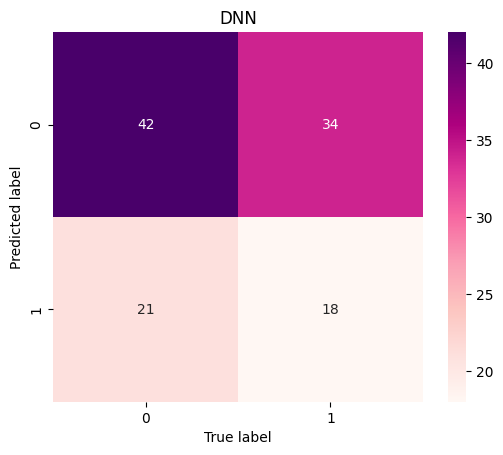

Accuracy:	0.521739
F1-score:	0.395604
Precision:	0.461538
Recall:		0.346154

Classification performance:
              precision    recall  f1-score   support

           0       0.55      0.67      0.60        63
           1       0.46      0.35      0.40        52

    accuracy                           0.52       115
   macro avg       0.51      0.51      0.50       115
weighted avg       0.51      0.52      0.51       115



In [18]:
mat_dnn = confusion_matrix(y, y_pred_dnn)
sns.heatmap(mat_dnn.T, square=True, annot=True, fmt='d', cmap='RdPu')
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.title("DNN")
plt.show()

print("Accuracy:\t%f" % accuracy_score(y, y_pred_dnn))
print("F1-score:\t%f" % f1_score(y, y_pred_dnn))
print("Precision:\t%f" % precision_score(y, y_pred_dnn))
print("Recall:\t\t%f" % recall_score(y, y_pred_dnn))
print("\nClassification performance:\n%s" % classification_report(y, y_pred_dnn))

### Integrated Models

### XGBoost（Extreme Gradient Boosting）

In [19]:
import xgboost as xgb

In [20]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.7, 0.9]
}

xgb_model = xgb.XGBClassifier()
grid_search = GridSearchCV(xgb_model, param_grid, cv=10, scoring='accuracy')
grid_search.fit(X, y)

print("Best parameters for XGBoost: ", grid_search.best_params_)

Best parameters for XGBoost:  {'colsample_bytree': 0.9, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.7}


In [21]:
xgb_model = xgb.XGBClassifier(
    colsample_bytree=0.9, 
    learning_rate=0.1, 
    max_depth=7, 
    n_estimators=500, 
    subsample=0.7,
    use_label_encoder=False
)

y_prob_xgb = np.zeros_like(y, dtype=float)

for train_idx, test_idx in cv.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    xgb_model.fit(X_train, y_train)
    y_prob_xgb[test_idx] = xgb_model.predict_proba(X_test)[:, 1]

y_pred_xgb = (y_prob_xgb > 0.5).astype(int)

print("\nPredicted Probabilities for XGBoost:")
print(y_prob_xgb)


Predicted Probabilities for XGBoost:
[0.9113043  0.9959842  0.91978276 0.28968361 0.35409638 0.01283397
 0.15150708 0.05639541 0.94458073 0.16305727 0.02597693 0.02691187
 0.08442254 0.75941902 0.03914353 0.06646032 0.10853269 0.9909752
 0.98267502 0.90153688 0.01033479 0.00144019 0.04755609 0.52820539
 0.13906693 0.24220245 0.37389433 0.08736603 0.22018874 0.58416826
 0.07046657 0.09912316 0.00813416 0.84126133 0.0158952  0.48588607
 0.81343836 0.06485264 0.94100416 0.02418549 0.18227127 0.07036322
 0.93836904 0.99571854 0.00548885 0.08118413 0.32153362 0.24564432
 0.06310773 0.00507469 0.39936602 0.15304701 0.19440822 0.41769597
 0.02686487 0.90269536 0.14639568 0.28707707 0.00456495 0.68693066
 0.82390743 0.43291453 0.58942497 0.48311329 0.7396515  0.04211948
 0.1665574  0.80980623 0.89834189 0.27003676 0.91332024 0.00544643
 0.00752516 0.54873139 0.87709796 0.04681002 0.02046329 0.91806513
 0.02186144 0.91676813 0.98522514 0.95572746 0.0439298  0.95810455
 0.98518282 0.08727308 0.

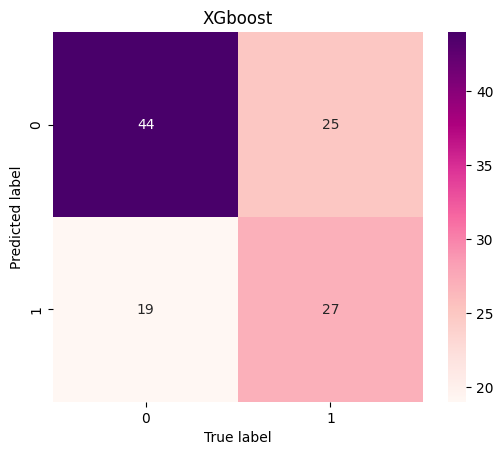

Accuracy:	0.617391
F1-score:	0.551020
Precision:	0.586957
Recall:		0.519231

Classification performance:
              precision    recall  f1-score   support

           0       0.64      0.70      0.67        63
           1       0.59      0.52      0.55        52

    accuracy                           0.62       115
   macro avg       0.61      0.61      0.61       115
weighted avg       0.61      0.62      0.61       115



In [22]:
mat_xgb = confusion_matrix(y, y_pred_xgb)
sns.heatmap(mat_xgb.T, square=True, annot=True, fmt='d', cmap='RdPu')
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.title("XGboost")
plt.show()

print("Accuracy:\t%f" % accuracy_score(y, y_pred_xgb))
print("F1-score:\t%f" % f1_score(y, y_pred_xgb))
print("Precision:\t%f" % precision_score(y, y_pred_xgb))
print("Recall:\t\t%f" % recall_score(y, y_pred_xgb))
print("\nClassification performance:\n%s" % classification_report(y, y_pred_xgb))

### CatBoost 

CatBoost's main advantage: It uses a special algorithm to encode classification features that often works better than traditional One-Hot Encoding or Label Encoding. Because it is not necessary to use the encoded dataset for training catboost, the original dataset can be used.

In [23]:
from catboost import CatBoostClassifier, Pool, cv
import catboost as cb

In [24]:
df_bat= pd.read_csv('/Users/quinne/Desktop/dissertation_dataset/halftime_dataframe_R.csv')
df_bat

,Result,match_number,team,opponent,gender,season,team_score,team_wickets,winner,toss_winner,home_advantage,venue_city,choose_to_bat,avg_score,avg_win_rate,avg_wickets_out,last_match_result
0,win,5,Oval Invincibles,London Spirit,female,2021,132,7,Oval Invincibles,London Spirit,no,"Lord's, London London",no,139.000000,1.000000,5.000000,win
1,win,6,Birmingham Phoenix,Manchester Originals,female,2021,113,9,Birmingham Phoenix,Birmingham Phoenix,no,"Old Trafford, Manchester Manchester",yes,128.000000,0.000000,6.000000,lose
2,win,7,Northern Superchargers,Trent Rockets,female,2021,149,7,Northern Superchargers,Northern Superchargers,no,"Trent Bridge, Nottingham Nottingham",yes,131.000000,1.000000,4.000000,win
3,lose,8,Welsh Fire,Southern Brave,female,2021,110,7,Southern Brave,Southern Brave,yes,"Sophia Gardens, Cardiff Cardiff",no,130.000000,0.000000,8.000000,lose
4,win,10,Trent Rockets,London Spirit,female,2021,151,4,Trent Rockets,Trent Rockets,no,"Lord's, London London",yes,116.000000,0.000000,7.000000,lose
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,lose,30,London Spirit,Birmingham Phoenix,male,2022,139,6,Birmingham Phoenix,Birmingham Phoenix,yes,"Lord's, London London",no,140.642857,0.428571,6.571429,lose
111,win,31,Northern Superchargers,Southern Brave,male,2022,135,8,Northern Superchargers,Southern Brave,yes,"Headingley, Leeds Leeds",no,152.714286,0.428571,6.000000,win
112,lose,32,Oval Invincibles,Manchester Originals,male,2022,143,9,Manchester Originals,Oval Invincibles,no,"Old Trafford, Manchester Manchester",yes,145.500000,0.571429,5.785714,win
113,lose,40,London Spirit,Manchester Originals,male,2022,150,7,Manchester Originals,London Spirit,no,"The Rose Bowl, Southampton Southampton",yes,140.533333,0.400000,6.533333,lose


In [25]:
df_bat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115 entries, 0 to 114
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Result             115 non-null    object 
 1   match_number       115 non-null    int64  
 2   team               115 non-null    object 
 3   opponent           115 non-null    object 
 4   gender             115 non-null    object 
 5   season             115 non-null    int64  
 6   team_score         115 non-null    int64  
 7   team_wickets       115 non-null    int64  
 8   winner             115 non-null    object 
 9   toss_winner        115 non-null    object 
 10  home_advantage     115 non-null    object 
 11  venue_city         115 non-null    object 
 12  choose_to_bat      115 non-null    object 
 13  avg_score          115 non-null    float64
 14  avg_win_rate       115 non-null    float64
 15  avg_wickets_out    115 non-null    float64
 16  last_match_result  115 non

In [27]:
columns_to_keep = ['Result', "match_number", "team", "opponent", 
                   "gender", 'season', 'home_advantage', 'venue_city',
                   'avg_score', 'avg_win_rate', 'avg_wickets_out', 'last_match_result']
df = df_bat[columns_to_keep]

In [28]:
print(df.shape)

(115, 12)


In [29]:
# Transforming the 'Result' column to binary format
df['Result'] = df['Result'].apply(lambda x: 1 if x == 'win' else 0)

In [30]:
# Splitting the data into X (features) and y (target)
X = df.drop(columns=['Result'])
y = df['Result']

# List of categorical features
cat_features = [
    'team', 'opponent', 'gender', 'home_advantage', 'venue_city', 'last_match_result'
]

In [31]:
# Initialize a base model
model = CatBoostClassifier(cat_features=cat_features, verbose=0)

# Parameter grid
grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [100, 500, 1000],
    'depth': [3, 5, 7],
    'l2_leaf_reg': [1, 3, 5]
}

# Grid search
grid_search_result = model.grid_search(grid, 
                                       X=Pool(X, label=y, cat_features=cat_features), 
                                       cv=10,  
                                       plot=False)

# Best parameters from grid search
best_params = grid_search_result['params']



bestTest = 0.6930869783
bestIteration = 2

0:	loss: 0.6930870	best: 0.6930870 (0)	total: 192ms	remaining: 15.3s

bestTest = 0.688026097
bestIteration = 21

1:	loss: 0.6880261	best: 0.6880261 (1)	total: 289ms	remaining: 11.4s

bestTest = 0.6915828762
bestIteration = 2

2:	loss: 0.6915829	best: 0.6880261 (1)	total: 376ms	remaining: 9.78s

bestTest = 0.6932450779
bestIteration = 2

3:	loss: 0.6932451	best: 0.6880261 (1)	total: 491ms	remaining: 9.45s

bestTest = 0.6940503282
bestIteration = 2

4:	loss: 0.6940503	best: 0.6880261 (1)	total: 593ms	remaining: 9.01s

bestTest = 0.6939549389
bestIteration = 1

5:	loss: 0.6939549	best: 0.6880261 (1)	total: 679ms	remaining: 8.49s

bestTest = 0.6931860882
bestIteration = 2

6:	loss: 0.6931861	best: 0.6880261 (1)	total: 792ms	remaining: 8.37s

bestTest = 0.6937300813
bestIteration = 2

7:	loss: 0.6937301	best: 0.6880261 (1)	total: 913ms	remaining: 8.33s

bestTest = 0.6952326105
bestIteration = 56

8:	loss: 0.6952326	best: 0.6880261 (1)	total: 1.06s

In [32]:
print("Best parameters for CatBoost: ", best_params)

Best parameters for CatBoost:  {'depth': 5, 'l2_leaf_reg': 1, 'iterations': 500, 'learning_rate': 0.1}


In [33]:
# Initialize the CatBoost model with the best parameters
model = CatBoostClassifier(
    depth=5, 
    l2_leaf_reg=1, 
    iterations=500, 
    learning_rate=0.1,
    cat_features=cat_features,
    verbose=0  
)

# Train the model on the entire dataset
model.fit(X, y)

In [34]:
# Train# 10-fold cross-validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=5)
y_prob_catboost = np.zeros_like(y, dtype=float)

for train_idx, test_idx in cv.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    
    model.fit(X_train, y_train)
    y_prob_catboost[test_idx] = model.predict_proba(X_test)[:, 1]

y_pred_catboost = (y_prob_catboost > 0.5).astype(int)

print("\nPredicted Probabilities for CatBoost:")
print(y_prob_catboost)


Predicted Probabilities for CatBoost:
[5.30821119e-01 9.90198143e-01 8.96523455e-01 5.70900785e-01
 8.42460865e-01 1.07165807e-02 9.66864931e-01 2.81015267e-01
 4.42639626e-01 7.63238143e-02 8.61152583e-03 7.27750373e-02
 7.02036720e-02 9.72015700e-01 5.21781272e-01 1.67995043e-02
 5.32299120e-01 9.62548061e-01 9.98758252e-01 5.29480096e-01
 9.88192766e-02 3.88980725e-04 1.22805217e-01 8.47843570e-01
 3.99444890e-02 2.60487769e-01 8.00472520e-01 8.76183607e-02
 3.77574013e-02 9.88338510e-01 2.02515964e-02 4.79287327e-01
 2.48700712e-03 5.50481727e-01 4.82150043e-01 4.10422022e-01
 8.35270132e-01 1.52535619e-01 9.47657736e-01 5.69036775e-02
 8.11789630e-01 4.59919315e-03 9.87252903e-01 9.23411412e-01
 2.13596578e-02 2.98337167e-02 7.20632877e-01 6.64932682e-02
 1.88593141e-01 1.46726010e-01 4.20736413e-03 4.29970148e-03
 7.71317456e-02 2.77910119e-01 3.44051672e-02 9.72929009e-01
 7.57069805e-01 3.07924205e-01 3.88336058e-02 3.05030644e-01
 9.11478710e-01 4.12040289e-01 4.96100466e-01 

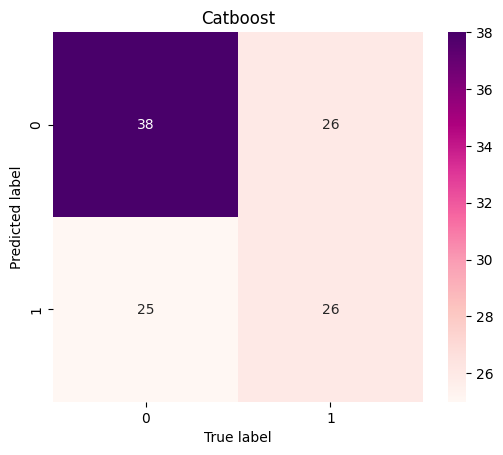

Accuracy:	0.556522
F1-score:	0.504854
Precision:	0.509804
Recall:		0.500000

Classification performance:
              precision    recall  f1-score   support

           0       0.59      0.60      0.60        63
           1       0.51      0.50      0.50        52

    accuracy                           0.56       115
   macro avg       0.55      0.55      0.55       115
weighted avg       0.56      0.56      0.56       115



In [35]:
mat_catboost = confusion_matrix(y, y_pred_catboost)  
sns.heatmap(mat_catboost.T, square=True, annot=True, fmt='d', cmap='RdPu')
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.title("Catboost")
plt.show()

print("Accuracy:\t%f" % accuracy_score(y, y_pred_catboost))  
print("F1-score:\t%f" % f1_score(y, y_pred_catboost))  
print("Precision:\t%f" % precision_score(y, y_pred_catboost))  
print("Recall:\t\t%f" % recall_score(y, y_pred_catboost))
print("\nClassification performance:\n%s" % classification_report(y, y_pred_catboost))  